# 1. Подготовка

In [1]:
import pandas as pd

data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
data.index = pd.to_datetime(data.index)
data = data.resample('1H').sum()
data

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


# 2. Анализ

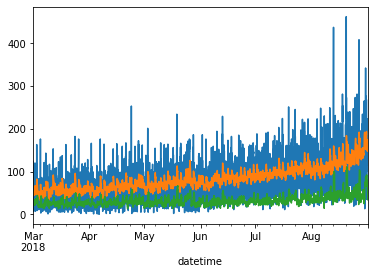

In [2]:
data['num_orders'].plot()
data['num_orders'].rolling(15).mean().plot()
data['num_orders'].rolling(15).std().plot()

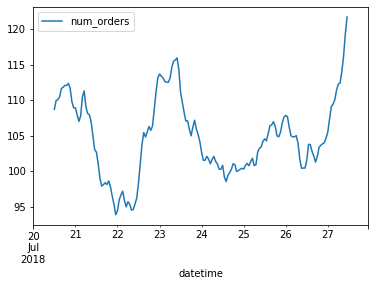

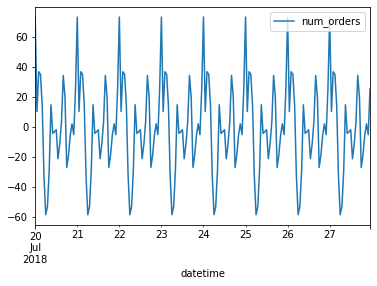

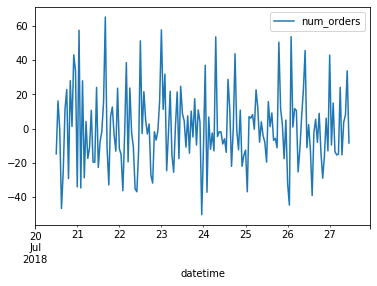

In [3]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposed = seasonal_decompose(data['2018-07-20':'2018-07-27'])
decomposed.trend.plot()
decomposed.seasonal.plot()
decomposed.resid.plot()

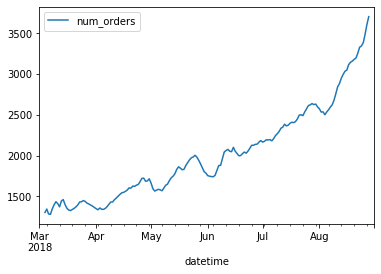

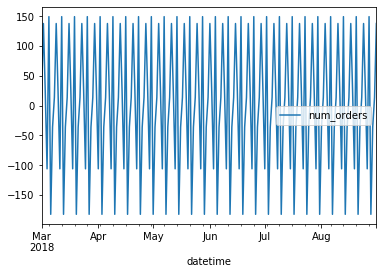

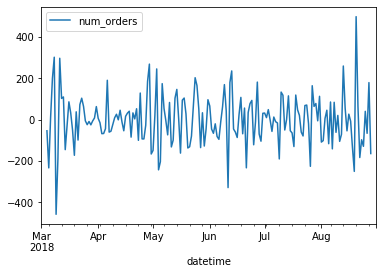

In [4]:
decomposed = seasonal_decompose(data.resample('1D').sum())
decomposed.trend.plot()
decomposed.seasonal.plot()
decomposed.resid.plot()

когда я попытался выполнить ресемплирование по одному часу, как было указано 
в задании, никакой сезонности заметить было нельзя, сейчас же, четко видны периодические колебания, с периодом 1 неделя

### Вывод: процесс не стационарный (существует положительный тренд), поэтому необходимо будет добавить несколько признаков со сдвигом

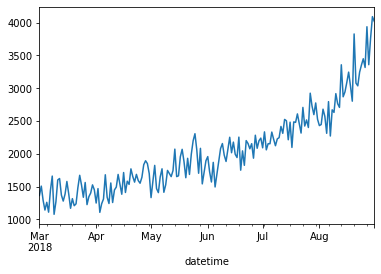

In [5]:
data['num_orders'].resample('1D').sum().plot()

Посмотрел суточную сезонность на срезе одной недели -- она действительно существует. Не сомневаюсь что в данной сфере существует и месячная сезонность тоже. Но, все таки, восходящий тренд должен действительно существовать. 

Безусловно, логично ожидать максимального числа заказов такси в аэропортах летом, и минимального -- в конце осени или зимой. С этой точки зрения существующие данные действительно очень неудобны, тк целиком охватывают "период роста" в гипотетическом цикле. Казалось бы информации для того, чтобы ответить на вопрос о существовании тренда не достаточно, но я бы хотел предложить сравнить динамику роста исследуемой величины в начале и в конце рассматриваемого периода. Невооруженным глазом, т.е. без сетки (параметр grid графика), можно наблюдать значительное увеличение скорости роста в конце лета (+1500 пунктов в Августе и +1000 за весь предшествовавший период, цифры приблизительные). Вдобавок, характер  изменения показателя (летом) скорее ближе к О(x^2), чем к О(х) (я же могу в таком контексте использовать это обозначение?), и снижения скорости роста, ожидаемого к концу лета, не наблюдается. 

В общем, к чему я веду: сезонность она есть, безусловно, но и тренд существует, и объясняться он должен, на мой взгляд, мультипликативным эффектом инвестиций: с ростом числа заказов в начале лета у фирмы появилось больше свободных средств, которые она, по всей видимости инвестировала в развитие компании (не обязательно интенсивное, т.е, например, модернизация автопарка, но и, вполне возможно, экстенсивное: банально наняла больше водителей, закупила дополнительные автомобили), повысив привлекательность, узнаваемость бренда, доступность и прочие бизнесовые показатели, что привело к росту числа клиентов, что выразилось, опять таки, в росте прибыли и тд. Число итераций зависит от не-/поворотливости менеджмента компании и объемов рынка. Таким образом, очень интенсивный рост в конце сезона (августе) вполне укладывается в парадигму наличия тренда.

# 3. Обучение

In [6]:
def make_features(data, max_lag, rolling_mean_size):
    buf = data.copy()
    buf['month'] = data.index.month
    buf['hour'] = data.index.hour
    
    buf['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        buf['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    buf['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    return buf

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
mf_params = [1, 1, 9999999999, 0]


model_tree = DecisionTreeRegressor()
model_regression = LinearRegression()

for model in (model_tree, model_regression):
    for i in range(1, 102, 25):
        for j in range(1, 102, 25):
            buf = make_features(data, i, j)
            buf = buf.dropna()
            features, target = buf.drop('num_orders', axis=1), buf['num_orders']
            features_train, features_test, target_train, target_test = train_test_split(features, target, train_size=0.8, shuffle=False)
            model.fit(features_train, target_train)
            prediction = model.predict(features_test)
            if mf_params[2] > mean_squared_error(target_test, prediction)**0.5:
                mf_params = list([i, j , mean_squared_error(target_test, prediction)**0.5, model])
            
print('({},{}) : {}\n{})'.format(*mf_params))

(101,1) : 36.0769428908622
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False))


Пока это мало о чем говорит, но по крайней мере стало понятно что лучше использовать модели на основе линейной регрессии и что исходный датасет нужно преобразовать с помощью make_features с параметрами 101 и 1 (всего 2,5% потеряли)

In [12]:
data = make_features(data, 101, 1).dropna()
data_train_valid, data_test = train_test_split(data, test_size=0.1, shuffle=False)


from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV
import numpy as np

model = LinearRegression()
features, target = data_train_valid.drop('num_orders', axis=1), data_train_valid['num_orders']
features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size=0.1, shuffle=False)


params = {
    'max_depth' : 8, 
    'num_leaves' : 64,
    'learning_rate' : 0.01,
    'num_iterations' : 300,
    'silent' : True}


# 4. Тестирование

40.850508921023234


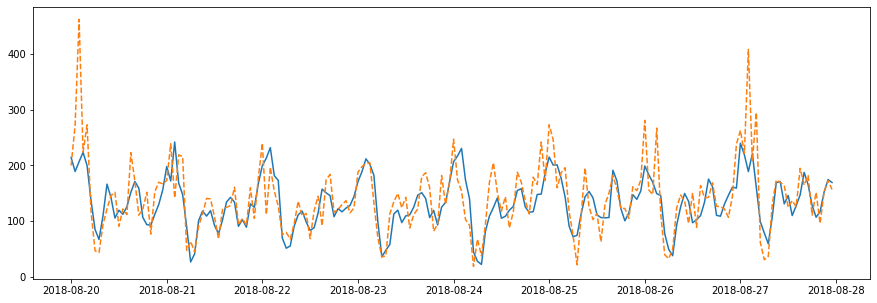

In [43]:
#model = grid_cv.best_estimator_
import matplotlib.pyplot as plt
model.fit(features_train, target_train)
prediction = model.predict(data_test.drop('num_orders', axis=1))
print(mean_squared_error(data_test['num_orders'], prediction)**0.5)
prediction = pd.Series(prediction)
prediction.index = data_test.index
plt.rcParams['figure.figsize']=(15,5)
plt.plot(prediction['2018-08-20':'2018-08-27'])
plt.plot(data_test['num_orders']['2018-08-20':'2018-08-27'], '--')

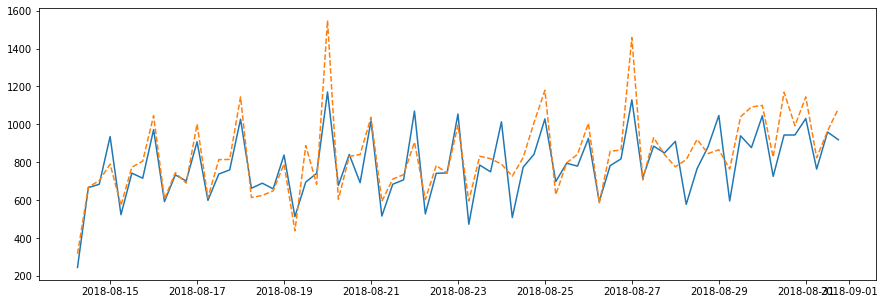

In [45]:
plt.plot(prediction.resample('6H').sum())
plt.plot(data_test['num_orders'].resample('6H').sum(), '--')

Вывод по графику: модель в целом работает хорошо, тк. её косяки в основном возикают в местах резких скачков, но при этом сезонность учитывается. Однако, все же видно, что такие скачки происходят довольно часто, т.е они не являются аномалиями. Стоит ли улучшать качества прогнозирования -- зависит от специфики бизнеса. Изучив информацию в интернете, могу высказать предположение, что в большинстве случаев это не целесообразно.

# Вывод:
Данные очень и очень неплохие, четко виден тренд, и амплитуда самых больших колебаний не превышает значения допустимой ошибки, поэтому несмотря на мой косяк (использовал гридсерч с кросс-валидацией, т.е происходило перемешивание, не подходящее для временных рядов) получился приемлемый результат. Если бы были даны не настолько приятные данные (здесь лучше всего подходит обыкновенная линейная регрессия) я бы использовал перебор в цикле по сетке параметров, сгенерированной с помощью ParameterGrid, но слава богу, все сложилось нормально.

Итог: лучшая модель -- линейная регрессия, в таблицу следует добавить максимально большое (для данной задачи около 450) количество столбцов log_n